In [33]:
import pandas as pd
import matplotlib.pyplot as plt

Importing the databases that we need


In [44]:
# loading in statistics for college players from 2009 to 2021
college_stats = pd.read_csv('CollegeBasketballPlayers2009-2021.csv')

# removing college players that were not drafted, i.e. have no draft pick number
college_stats = college_stats[college_stats['pick'].notna()]

# dropping all the coloumns that are not going to be used in estimation
cols = ['player_name', 'pick', 'GP', 'Min_per', 'pts', 'oreb', 'dreb', 'ast', 'blk', 'stl', 'FTM', 'FT_per', 'TPM', 'TP_per', 'TS_per', 'TO_per', 'ast/tov', 'Ortg', 'drtg']
college_stats = college_stats[cols]

# loading in career stats for NBA - ends with the 2021 nba season
# WS from 2021-2022 and 2022-2023 season not included
nba_stats = pd.read_csv('draft-data-20-years.csv')

# removing all columns except win share which is our target
nba_stats = nba_stats[['Player', 'WS']]

# joining college stats on player Name to add target of WS
college_stats = college_stats.merge(nba_stats, left_on='player_name', right_on='Player')
college_stats = college_stats.drop(columns=['Player'])

# sorting df by draft pick for easier visualiztion and validation
data = college_stats.sort_values(by='pick')

# making sure we have a WS for every player in our data set, remove those who don't 
data = data[data['WS'].notna()]
data = data.drop_duplicates(subset=['player_name'], keep='last')

data.head() # total 558 players to work with

<ipython-input-44-e88312d12317>:2: DtypeWarning: Columns (27) have mixed types. Specify dtype option on import or set low_memory=False.
  college_stats = pd.read_csv('CollegeBasketballPlayers2009-2021.csv')


,player_name,pick,GP,Min_per,pts,oreb,dreb,ast,blk,stl,FTM,FT_per,TPM,TP_per,TS_per,TO_per,ast/tov,Ortg,drtg,WS
666,Anthony Bennett,1.0,34,67.8,15.7941,2.3824,5.5882,0.9118,1.1765,0.7059,117,0.696,36,0.383,60.36,15.3,0.492093,112.8,89.4038,0.5
1002,Ben Simmons,1.0,33,86.5,19.1515,3.1212,8.6364,4.7879,0.8182,1.9697,199,0.670,1,0.333,59.95,18.6,1.423445,112.9,97.3738,30.4
1139,Deandre Ayton,1.0,35,82.5,20.1143,3.3714,8.2000,1.6286,1.8857,0.5714,140,0.733,12,0.343,64.98,13.1,0.826113,126.7,97.4640,22.1
1323,Anthony Edwards,1.0,31,81.3,19.0625,0.7500,4.4688,2.8438,0.5625,1.3438,127,0.770,69,0.291,51.73,15.4,1.045976,103.0,102.7740,3.9
802,Andrew Wiggins,1.0,35,81.4,17.0571,2.1714,3.6857,1.5429,0.9714,1.1714,176,0.775,43,0.341,56.34,15.9,0.675023,112.3,101.7120,23.5


Cleaning the Data

In [37]:
# filling in means for NaN values in stats
# not many NaN values, because we are taking drafted (i.e. high value players, which typically have complete statistics)

# we do not do this for picks over WS cause we already filter out NaN values for them
data.GP = data.GP.fillna(data.GP.mean())
data.Min_per = data.Min_per.fillna(data.Min_per.mean())
data.pts = data.pts.fillna(data.pts.mean())
data.oreb = data.oreb.fillna(data.oreb.mean())
data.dreb = data.dreb.fillna(data.dreb.mean())
data.ast = data.ast.fillna(data.ast.mean())
data.blk = data.blk.fillna(data.blk.mean())
data.stl = data.stl.fillna(data.stl.mean())
data.FTM = data.FTM.fillna(data.FTM.mean())
data.FT_per = data.FT_per.fillna(data.FT_per.mean())
data.TPM = data.TPM.fillna(data.TPM.mean())
data.TP_per = data.TP_per.fillna(data.TP_per.mean())
data.TS_per = data.TS_per.fillna(data.TS_per.mean())
data.TO_per = data.TO_per.fillna(data.TO_per.mean())
data['ast/tov'] = data['ast/tov'].fillna(data['ast/tov'].mean())
data.Ortg = data.Ortg.fillna(data.Ortg.mean())
data.drtg = data.drtg.fillna(data.drtg.mean())

data.head() # cleaned data

AttributeError: ignored

Correlation Matrix

In [45]:
corr = data.corr().abs()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-45-e01d04d4f8c2>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr().abs()
<ipython-input-45-e01d04d4f8c2>:2: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,pick,GP,Min_per,pts,oreb,dreb,ast,blk,stl,FTM,FT_per,TPM,TP_per,TS_per,TO_per,ast/tov,Ortg,drtg,WS
pick,1.00,0.11,0.15,0.22,0.17,0.19,0.07,0.18,0.17,0.26,0.04,0.01,0.04,0.21,0.03,0.03,0.19,0.21,0.37
GP,0.11,1.00,0.55,0.10,0.08,0.04,0.08,0.04,0.07,0.38,0.01,0.24,0.04,0.06,0.10,0.13,0.20,0.01,0.13
Min_per,0.15,0.55,1.00,0.69,0.08,0.36,0.50,0.04,0.47,0.67,0.33,0.51,0.27,0.15,0.18,0.32,0.26,0.18,0.15
pts,0.22,0.10,0.69,1.00,0.15,0.48,0.45,0.02,0.42,0.79,0.42,0.49,0.28,0.34,0.33,0.15,0.39,0.12,0.15
oreb,0.17,0.08,0.08,0.15,1.00,0.67,0.39,0.62,0.15,0.21,0.34,0.50,0.41,0.26,0.15,0.48,0.23,0.41,0.19
dreb,0.19,0.04,0.36,0.48,0.67,1.00,0.05,0.53,0.07,0.40,0.05,0.14,0.08,0.26,0.17,0.24,0.20,0.39,0.16
ast,0.07,0.08,0.50,0.45,0.39,0.05,1.00,0.36,0.63,0.38,0.33,0.44,0.32,0.06,0.18,0.77,0.07,0.24,0.06
blk,0.18,0.04,0.04,0.02,0.62,0.53,0.36,1.00,0.18,0.03,0.31,0.45,0.38,0.26,0.02,0.44,0.11,0.48,0.15
stl,0.17,0.07,0.47,0.42,0.15,0.07,0.63,0.18,1.00,0.36,0.26,0.37,0.28,0.02,0.07,0.48,0.08,0.08,0.18
FTM,0.26,0.38,0.67,0.79,0.21,0.40,0.38,0.03,0.36,1.00,0.37,0.28,0.14,0.27,0.19,0.09,0.33,0.01,0.23


Splitting the Data

In [39]:
from sklearn.model_selection import train_test_split

# we remove pick as the goal is to determine the value of a college prospect
# therefore their draft order cannot be considered although it has a high correlation
X = data.drop(['pick','player_name', 'WS'], axis = 1)
y = data['WS']

# split the data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

X_train

,Ortg,drtg
1250,110.8,93.6734
597,107.8,98.0693
76,120.7,98.6762
1327,104.2,93.4429
430,109.7,106.7820
...,...,...
182,111.2,91.3455
83,118.8,89.7454
595,133.8,79.6300
608,105.4,90.6938


Preprocessing Data

In [40]:
from sklearn import preprocessing

# defining an object of MinMaxScaler()
min_max_scaler = preprocessing.MinMaxScaler()

# normalize values between 0 and 1 using the training data
X_train_scaled = min_max_scaler.fit_transform(X_train)

# visualizing shape of scaled data
X_train_scaled.shape

(390, 2)

Linear Regression

In [41]:
from sklearn import linear_model

# defining the model as an object of LinearRegression()
lin_model = linear_model.LinearRegression()

# fit the model on the scaled training data
lin_model.fit(X_train_scaled, y_train)

lin_model.score(X_train_scaled, y_train)

0.08830061905381836

In [42]:
# Model evaluation with normalization using test set 
min_max_scaler_2 = preprocessing.MinMaxScaler()

X_test_scaled = min_max_scaler_2.fit_transform(X_test)

# calculate the R^2 score
lin_model.score(X_test_scaled, y_test)

0.024760123722601723

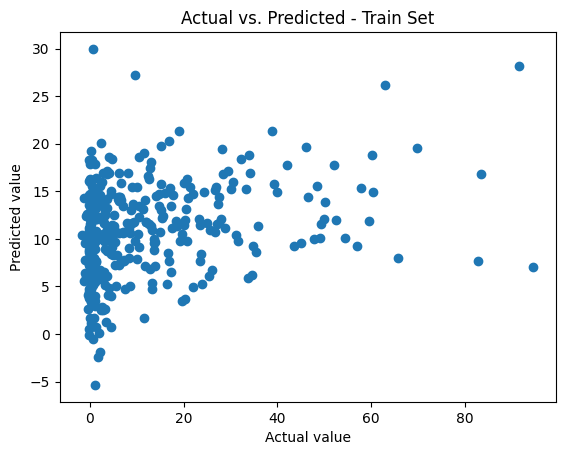

In [43]:
# calculate the predicted values for training data
y_pred_train = lin_model.predict(X_train_scaled)

# visualize the difference between actual and predicted data using scatter plot
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual value")
plt.ylabel("Predicted value")
plt.title("Actual vs. Predicted - Train Set")
plt.show()